OpSeten Play Shots - Expected Behind Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import set_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 6
model_name = "expected_behind_set"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_BEHIND

Features

In [6]:
FEATURES = ModellingDataContract.feature_list_set_behind

Load Data

In [7]:
df_modelling = pd.read_csv(set_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,GoalTrainingSet,GoalTestSet,GoalValidationSet,BehindTrainingSet,BehindTestSet,BehindValidationSet,MissTrainingSet,MissTestSet,MissValidationSet
11052,208,possGain,behind,1663.0,4,634,683.0,Geelong,Geelong,Tom Hawkins,Tom_Hawkins,Kick,41.0,25.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,0,1,1,0,105.0,32.0,73.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,48.0,48.0,26.0,25.0,21.0,21.0,14.0,683.0,644.0,642.0,641.0,49.0,39.0,8.062258,39.0,25.0,46.324939,0.570040,32.660913,0.116867,6.695990,0.364585,20.889203,1521.0,3.663562,True,True,False,False,True,False,False,True,False,False
11053,212,kickIn,goal,1730.0,4,787,885.0,Geelong,Geelong,Patrick Dangerfield,Patrick_Dangerfield,Kick,51.0,43.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,107.0,33.0,74.0,Kick,Contested Mark,Contest Target,Kick Inside 50 Result,51.0,53.0,53.0,53.0,43.0,38.0,38.0,38.0,885.0,852.0,851.0,850.0,98.0,33.0,5.385165,29.0,43.0,51.865210,0.977446,56.003541,0.069260,3.968302,0.214332,12.280314,841.0,3.367296,True,False,False,True,True,False,False,True,False,False
11054,213,centreBounce,goal,1754.0,4,956,979.0,Sydney,Sydney,Paddy McCartin,Paddy_McCartin,Kick,66.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,119.0,33.0,86.0,Kick,Free For,Kick Inside 50 Result,Kick Into F50,66.0,74.0,74.0,27.0,0.0,0.0,0.0,17.0,979.0,977.0,968.0,967.0,23.0,2.0,8.000000,14.0,0.0,14.000000,0.000000,0.000000,0.482343,27.636207,2.588598,148.315731,196.0,2.639057,True,True,False,False,True,False,False,False,True,False
11055,219,centreBounce,goal,1846.0,4,1252,1266.0,Sydney,Sydney,Chad Warner,Chad_Warner,Kick,26.0,3.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,125.0,39.0,86.0,Kick,Uncontested Mark,Ground Kick,Handball,26.0,18.0,-5.0,-2.0,3.0,2.0,-4.0,3.0,1266.0,1265.0,1264.0,1260.0,14.0,1.0,8.062258,54.0,3.0,54.083269,0.055499,3.179830,0.118569,6.793500,0.365993,20.969862,2916.0,3.988984,True,True,False,False,True,False,False,True,False,False
11056,228,centreBounce,goal,1912.0,4,1519,1560.0,Geelong,Geelong,Jeremy Cameron,Jeremy_Cameron,Kick,41.0,21.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,131.0,45.0,86.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,41.0,49.0,49.0,25.0,21.0,17.0,17.0,33.0,1560.0,1535.0,1532.0,1531.0,41.0,25.0,8.944272,39.0,21.0,44.294469,0.493941,28.300756,0.127885,7.327246,0.400462,22.944787,1521.0,3.663562,True,True,False,False,True,False,False,True,False,False


In [8]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [9]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,GoalTrainingSet,GoalTestSet,GoalValidationSet,BehindTrainingSet,BehindTestSet,BehindValidationSet,MissTrainingSet,MissTestSet,MissValidationSet,ballUp,centreBounce,kickIn,possGain,throwIn
9,101,possGain,goal,929.0,2,1504,1576.0,Brisbane Lions,Brisbane Lions,Oscar McInerney,Oscar_McInerney,Kick,59.0,-6.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,6,0,44.0,46.0,-2.0,Kick,Contested Mark,Kick,Mark On Lead,59.0,70.0,44.0,48.0,-6.0,-4.0,39.0,33.0,1576.0,1542.0,1540.0,1508.0,72.0,34.0,11.180340,19.0,6.0,19.924859,0.305879,17.525568,0.314407,18.014187,1.196693,68.565478,361.0,2.944439,True,True,False,False,False,True,False,True,False,False,0,0,0,1,0
10,108,possGain,goal,982.0,2,1782,1859.0,Sydney,Sydney,Sam Reid,Sam_Reid,Kick,40.0,36.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,50.0,46.0,4.0,Kick,Uncontested Mark,Kick,Uncontested Mark,40.0,44.0,43.0,50.0,36.0,32.0,48.0,40.0,1859.0,1835.0,1833.0,1814.0,77.0,24.0,5.656854,38.0,36.0,52.345009,0.758378,43.451842,0.089092,5.104600,0.275545,15.787586,1444.0,3.637586,True,True,False,False,False,True,False,False,True,False,0,0,0,1,0
11,122,possGain,goal,1074.0,3,28,72.0,Sydney,Sydney,Nick Blakey,Nick_Blakey,Kick,28.0,-14.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,51.0,52.0,-1.0,Kick,Uncontested Mark,Kick Inside 50 Result,Kick Into F50,28.0,35.0,35.0,32.0,-14.0,-12.0,-12.0,35.0,72.0,38.0,36.0,36.0,44.0,34.0,7.280110,50.0,14.0,51.923020,0.273009,15.642246,0.119147,6.826615,0.368686,21.124166,2500.0,3.912023,True,True,False,False,False,True,False,True,False,False,0,0,0,1,0
15,144,throwIn,goal,1283.0,3,1014,1041.0,Sydney,Sydney,Callum Mills,Callum_Mills,Kick,29.0,-3.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,58.0,71.0,-13.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,29.0,37.0,37.0,22.0,-3.0,-2.0,-2.0,-16.0,1041.0,1019.0,1018.0,1017.0,27.0,22.0,8.062258,49.0,3.0,49.091751,0.061148,3.503532,0.130680,7.487397,0.405895,23.256079,2401.0,3.891820,True,True,False,False,False,True,False,True,False,False,0,0,0,0,1
18,173,possGain,goal,1521.0,3,2013,2063.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,51.0,13.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,6,0,6,65.0,101.0,-36.0,Kick,Uncontested Mark,Kick,Uncontested Mark,51.0,57.0,32.0,36.0,13.0,8.0,-12.0,-12.0,2063.0,2024.0,2023.0,2020.0,50.0,39.0,7.810250,27.0,13.0,29.966648,0.448723,25.709954,0.194647,11.152463,0.643304,36.858597,729.0,3.295837,True,False,False,True,False,True,False,True,False,False,0,0,0,1,0


Preprocess Data

In [12]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [13]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [14]:
X_train_preproc.shape, X_test_preproc.shape

((7076, 5), (2212, 5))

In [15]:
X_train_preproc.head()

,x0,y0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle
0,46.0,-41.0,52.009614,0.908067,0.075999
1,52.0,35.0,43.600459,0.931882,0.088007
3,59.0,27.0,33.015148,0.957589,0.112618
4,33.0,12.0,46.572524,0.260602,0.133410
5,52.0,36.0,44.407207,0.945311,0.084822


In [16]:
X_test_preproc.head()

,x0,y0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle
9,59.0,-6.0,19.924859,0.305879,0.314407
10,40.0,36.0,52.345009,0.758378,0.089092
11,28.0,-14.0,51.923020,0.273009,0.119147
15,29.0,-3.0,49.091751,0.061148,0.130680
18,51.0,13.0,29.966648,0.448723,0.194647


Load Model

In [17]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [18]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8079822620295684, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.4873515608096657, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.30662681044857415, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=24, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': 1,
                                    'Distance_to_Middle_Goal': 1,
                                    'Visible_Goal_Angle': -1, 'x0': 1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [19]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [20]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [21]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [22]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [23]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas',
                                                          'xgb_probas_cal':'old_cal_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas',
                                                        'xgb_probas_cal':'old_cal_probas'})

In [24]:
training_data.shape, compare_train_data.shape

((7076, 79), (7076, 12))

In [25]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [26]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='old_cal_probas',
                                       compare_label_name="old_preds"
                                       )

In [27]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name = "old_cal_probas",
                                       compare_label_name="old_preds"
                                       )

Model Averages

In [28]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas', "old_cal_probas"]].describe()

,Behind,xgb_probas,xgb_cal_probas,old_probas,old_cal_probas
count,7076.000000,7076.000000,7076.000000,7076.000000,7076.000000
mean,0.333522,0.336907,0.333615,0.334970,0.333929
std,0.471504,0.108719,0.115228,0.107138,0.111177
min,0.000000,0.045798,0.022509,0.060405,0.040715
25%,0.000000,0.305802,0.306654,0.310565,0.316505
50%,0.000000,0.362394,0.365509,0.363376,0.368032
75%,1.000000,0.406066,0.407471,0.411039,0.410769
max,1.000000,0.562040,0.532829,0.541814,0.510595


In [29]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas', "old_cal_probas"]].describe()

,Behind,xgb_probas,xgb_cal_probas,old_probas,old_cal_probas
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,0.333635,0.336249,0.332912,0.333988,0.332723
std,0.471618,0.108584,0.115322,0.108463,0.112650
min,0.000000,0.045798,0.022509,0.060405,0.040715
25%,0.000000,0.302559,0.303137,0.300943,0.306652
50%,0.000000,0.362636,0.365750,0.371016,0.375122
75%,1.000000,0.403615,0.405197,0.414464,0.413704
max,1.000000,0.536520,0.514790,0.541814,0.510595


Plots

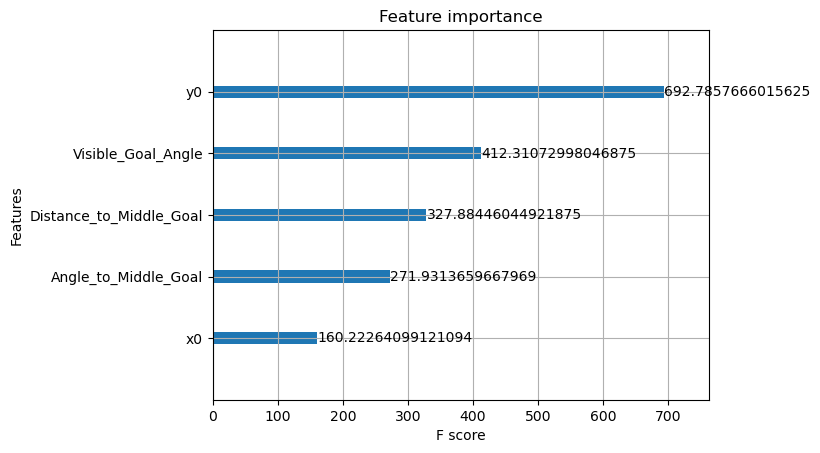

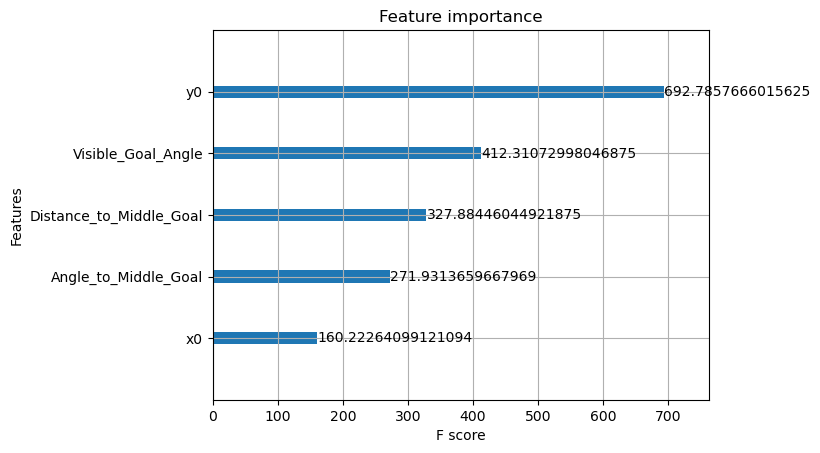

In [30]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

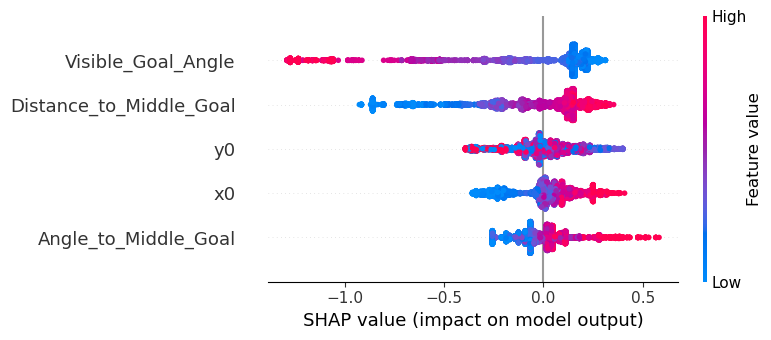

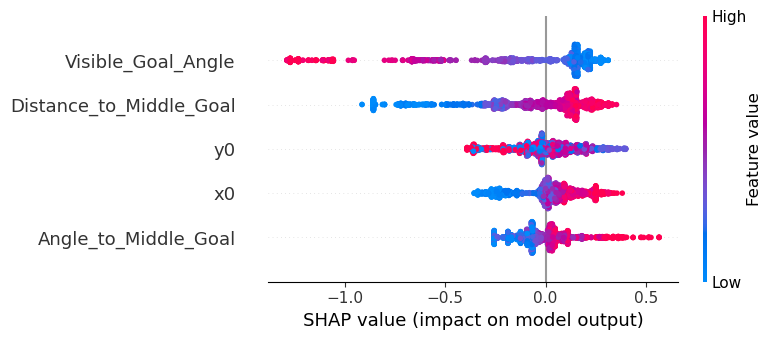

In [31]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [32]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Visible_Goal_Angle',
 'Distance_to_Middle_Goal',
 'y0',
 'x0',
 'Angle_to_Middle_Goal']

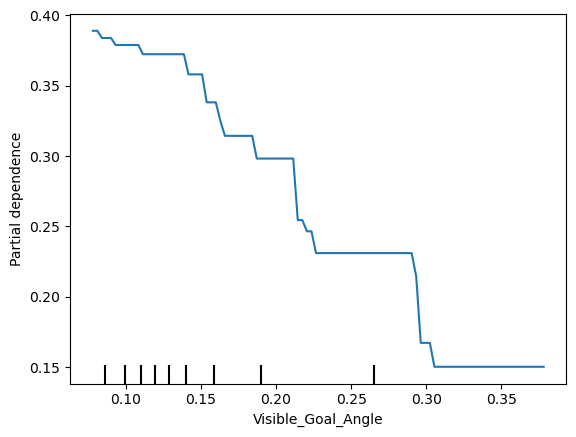

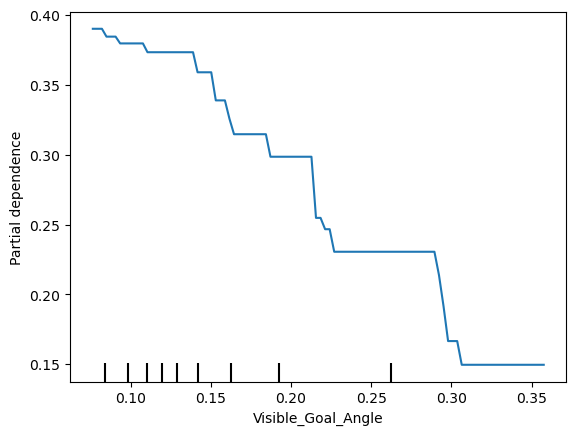

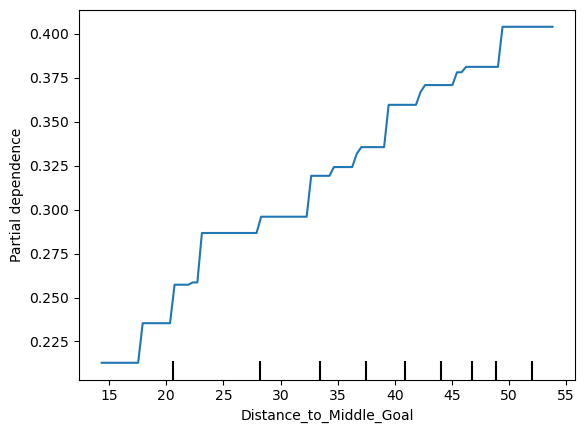

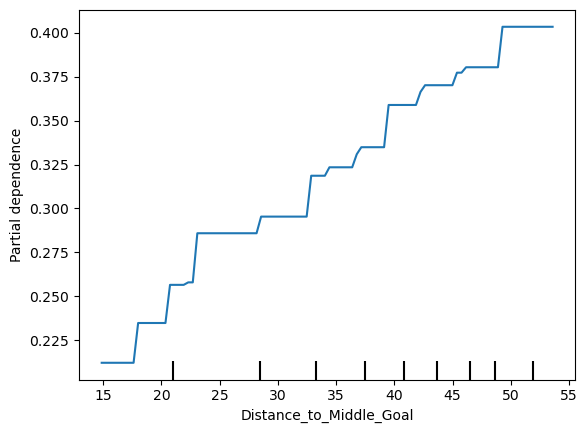

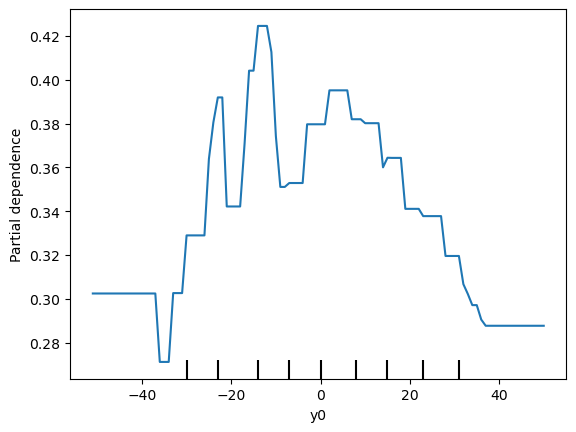

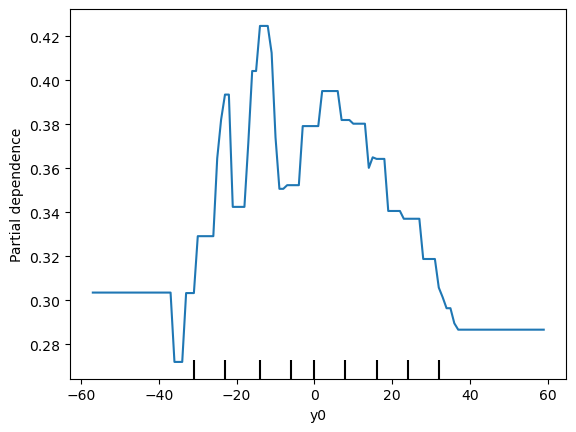

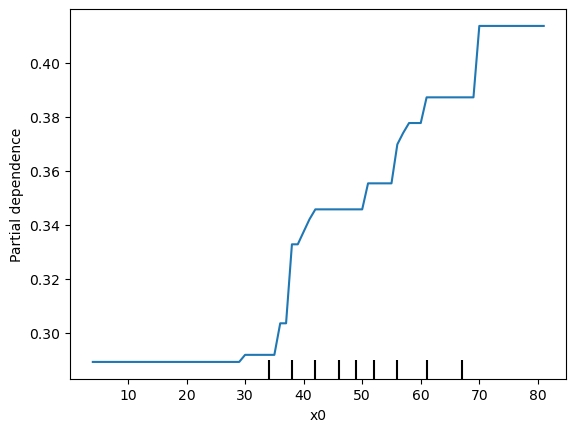

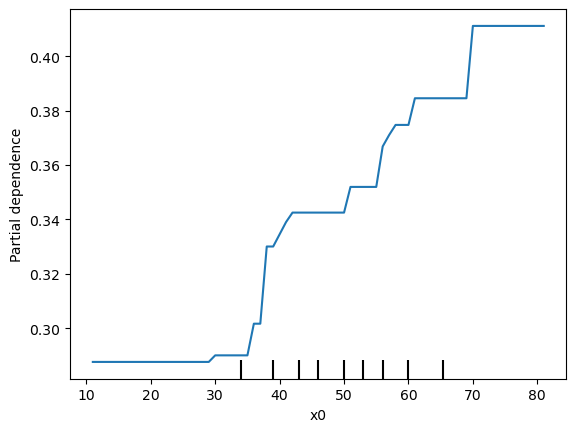

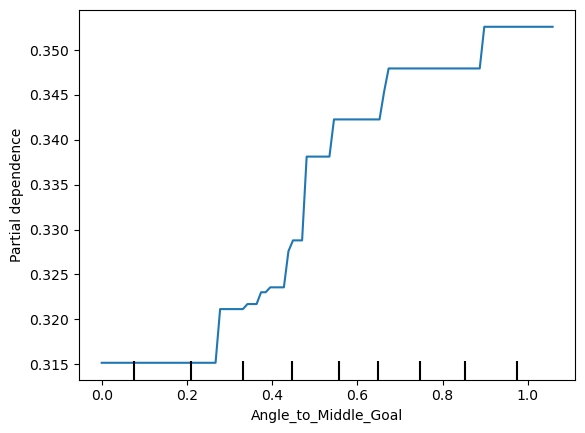

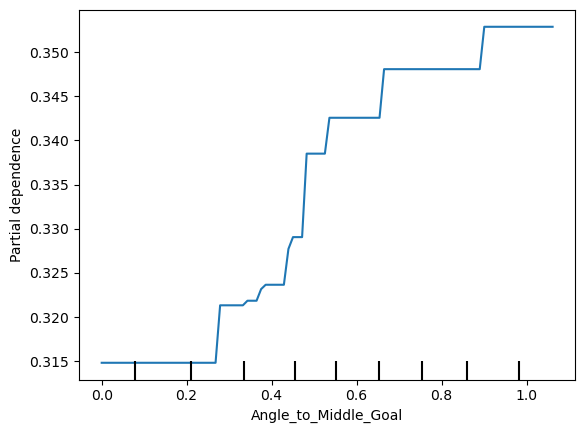

In [33]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

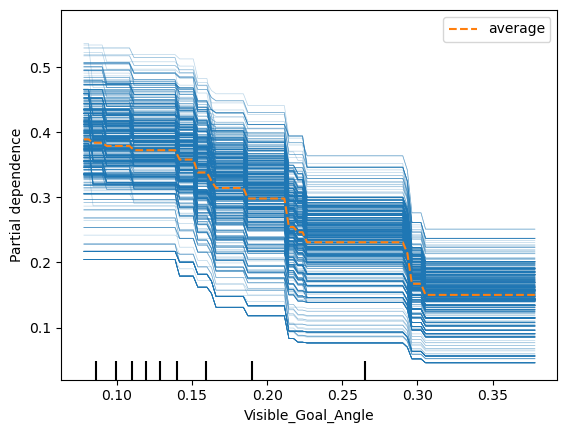

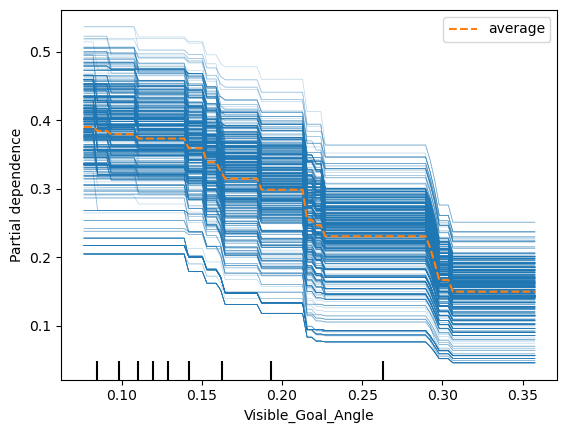

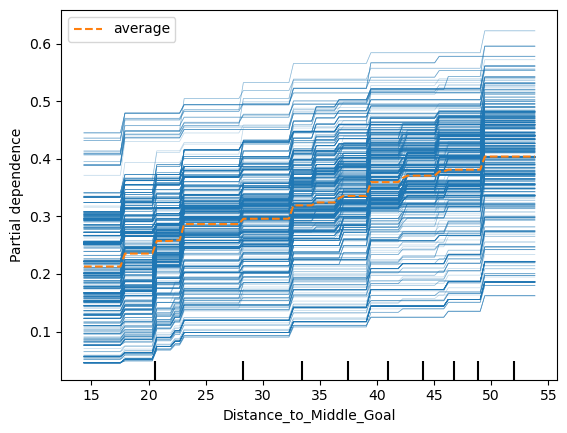

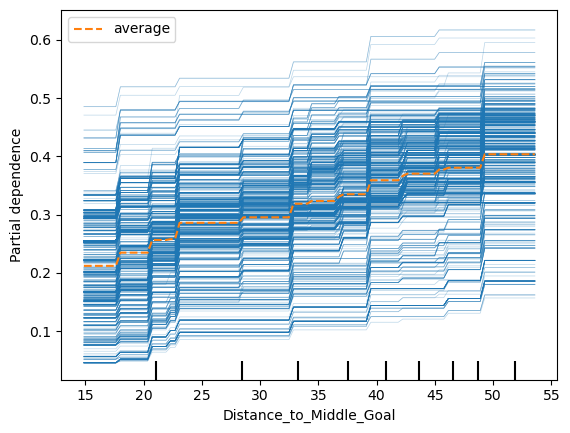

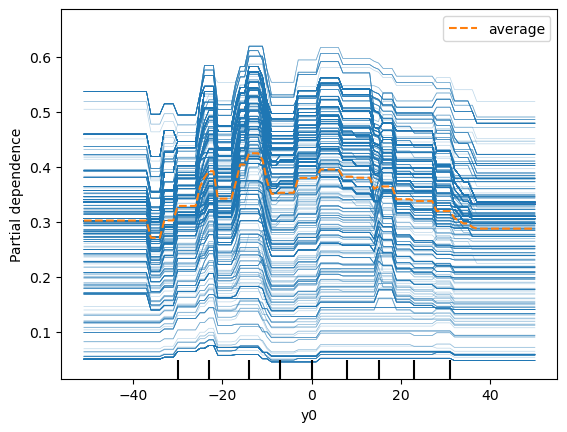

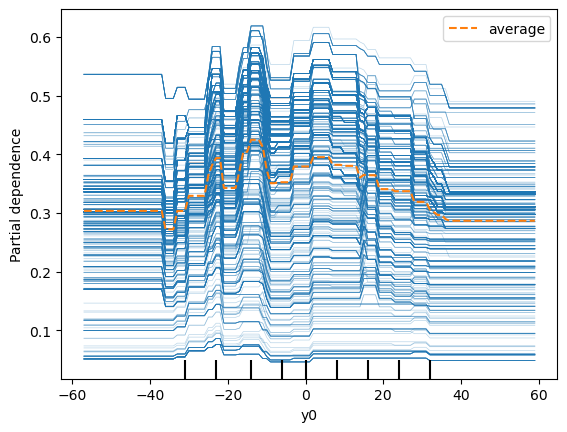

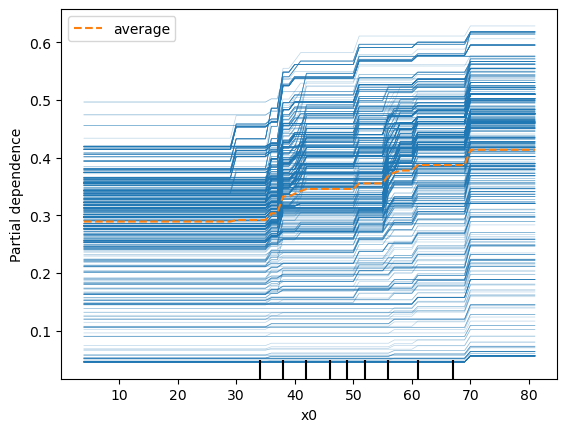

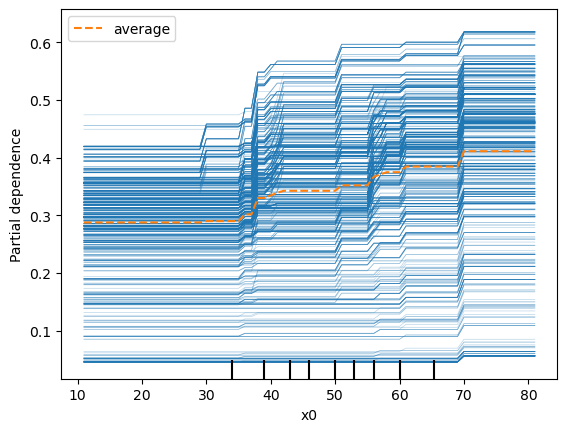

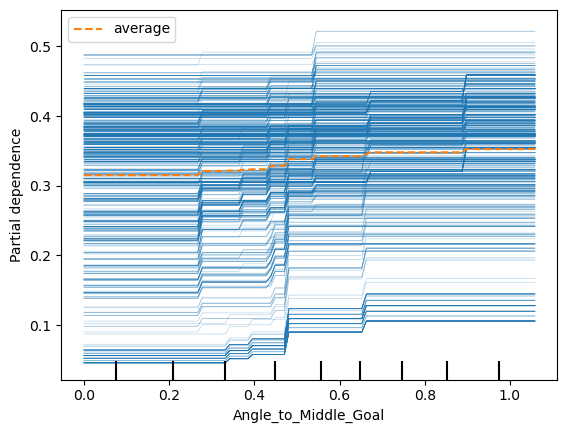

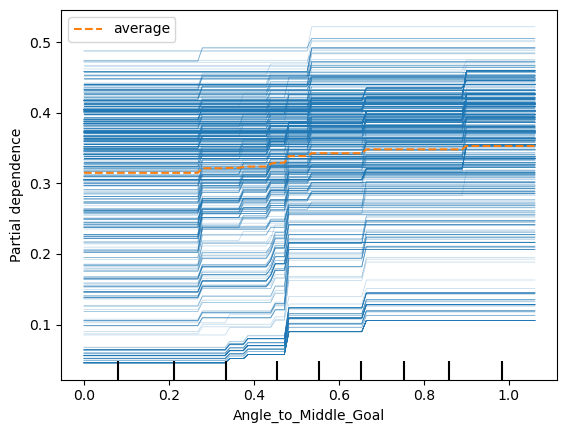

In [34]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

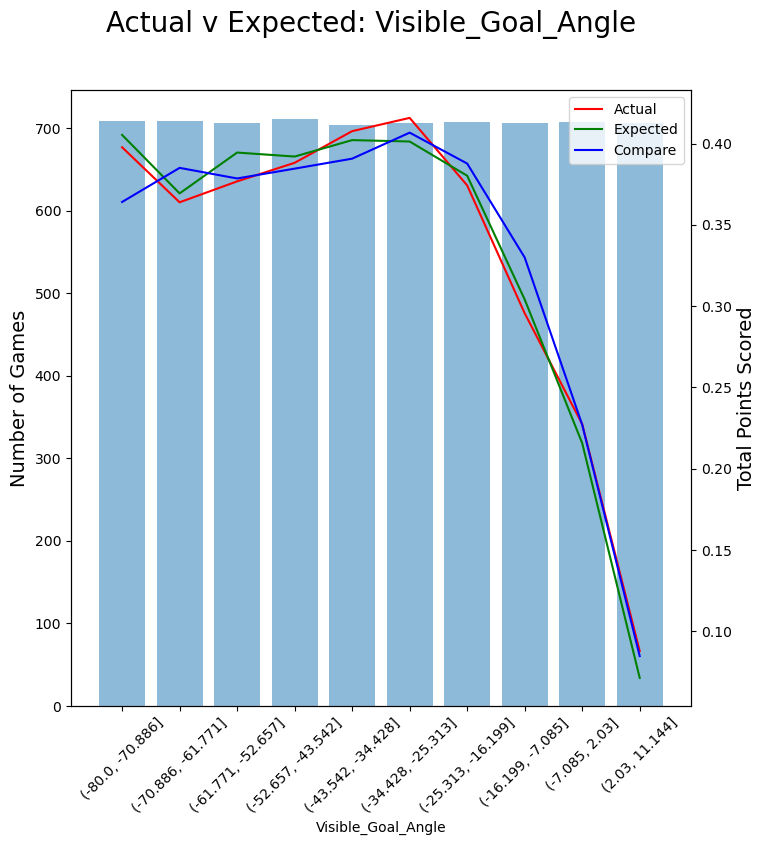

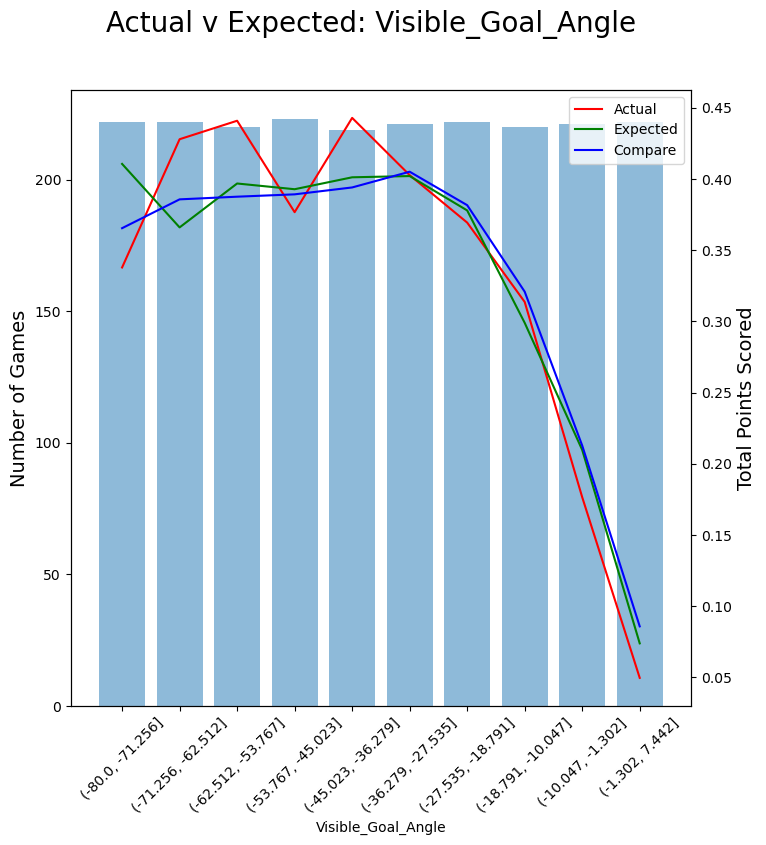

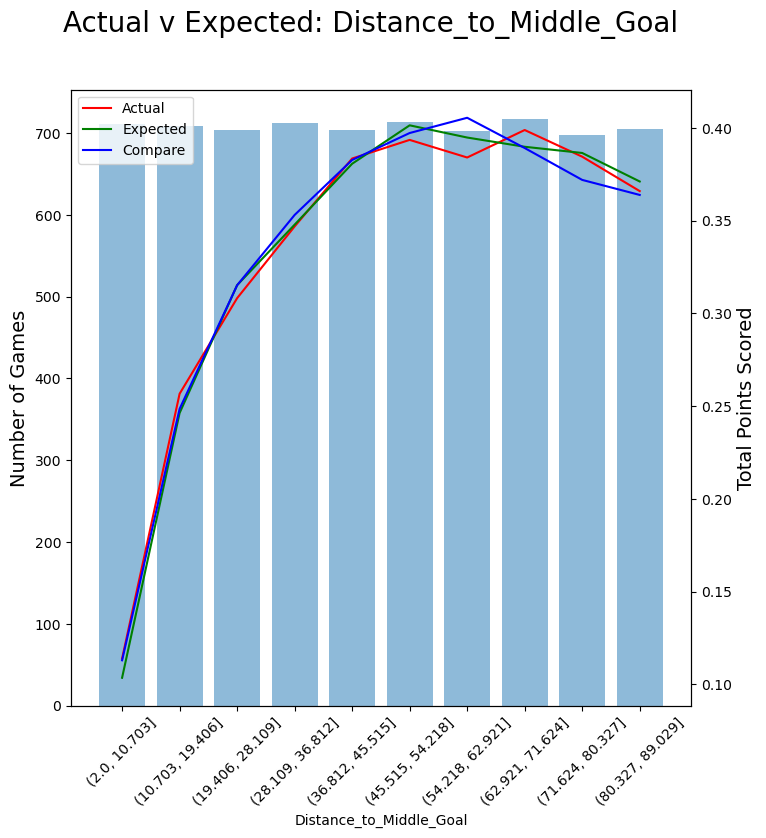

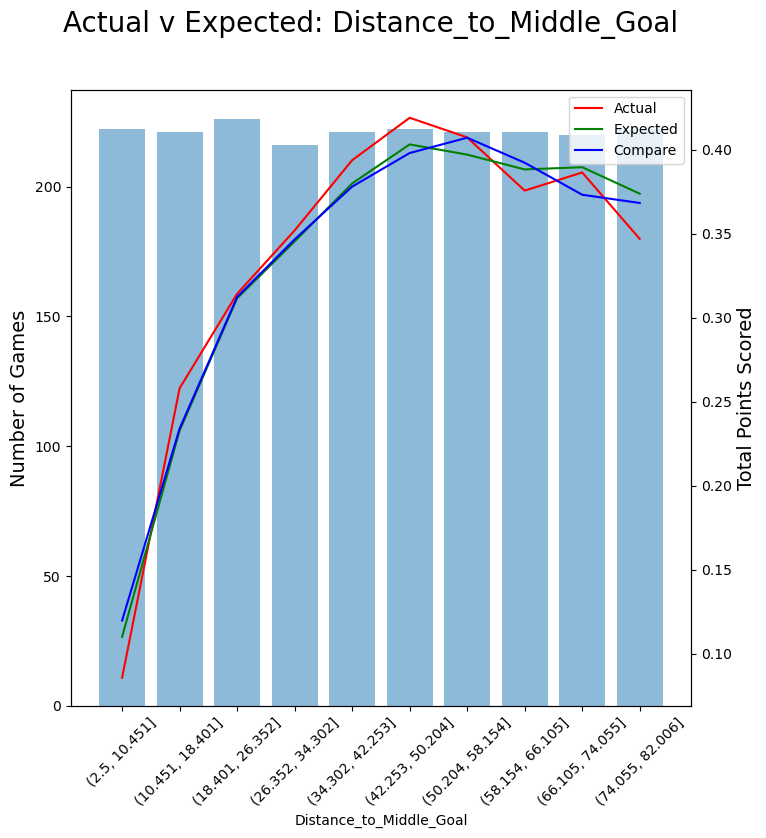

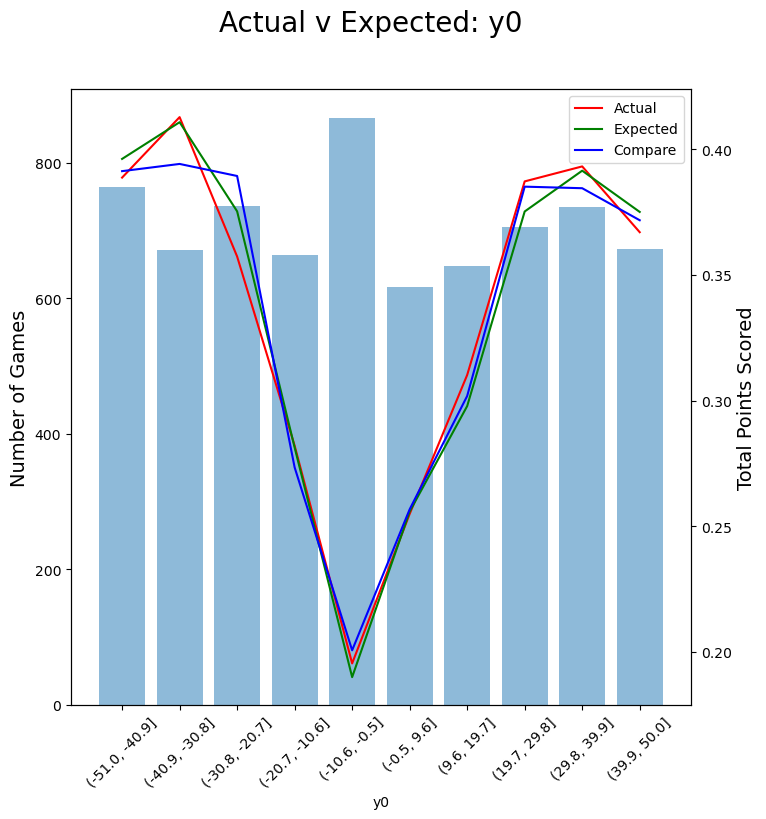

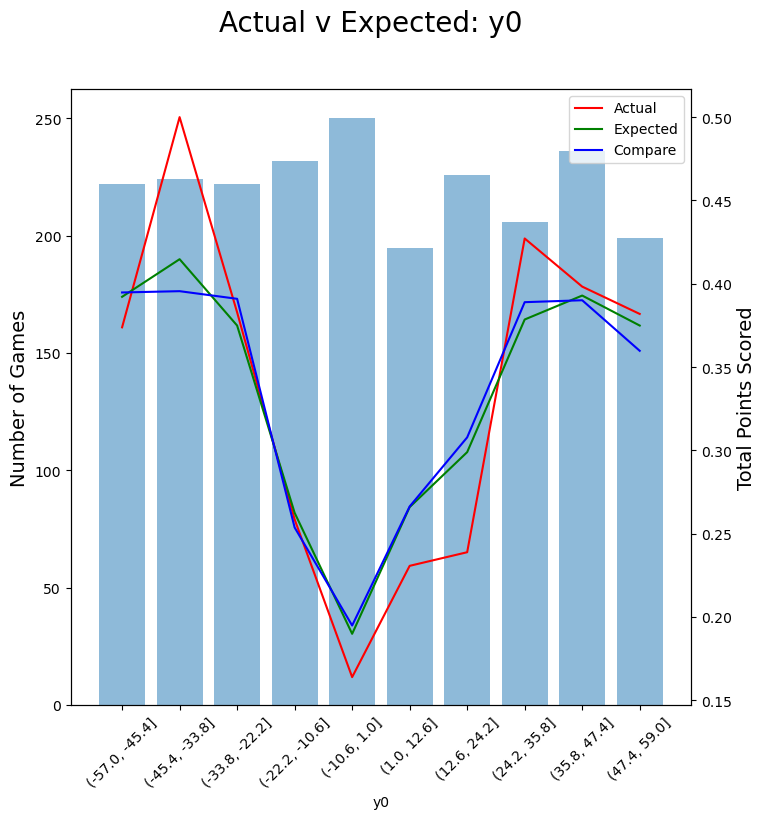

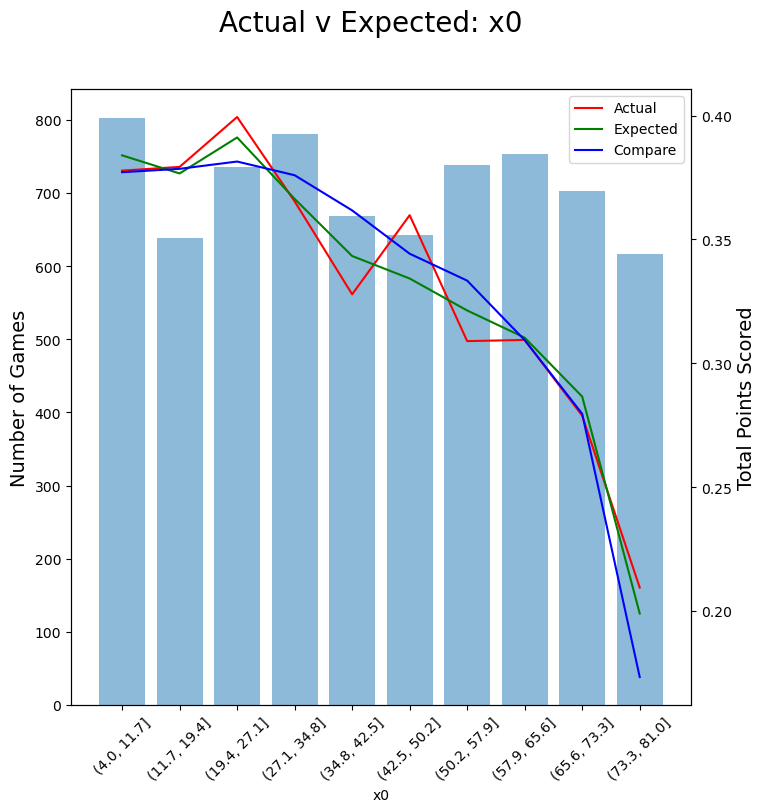

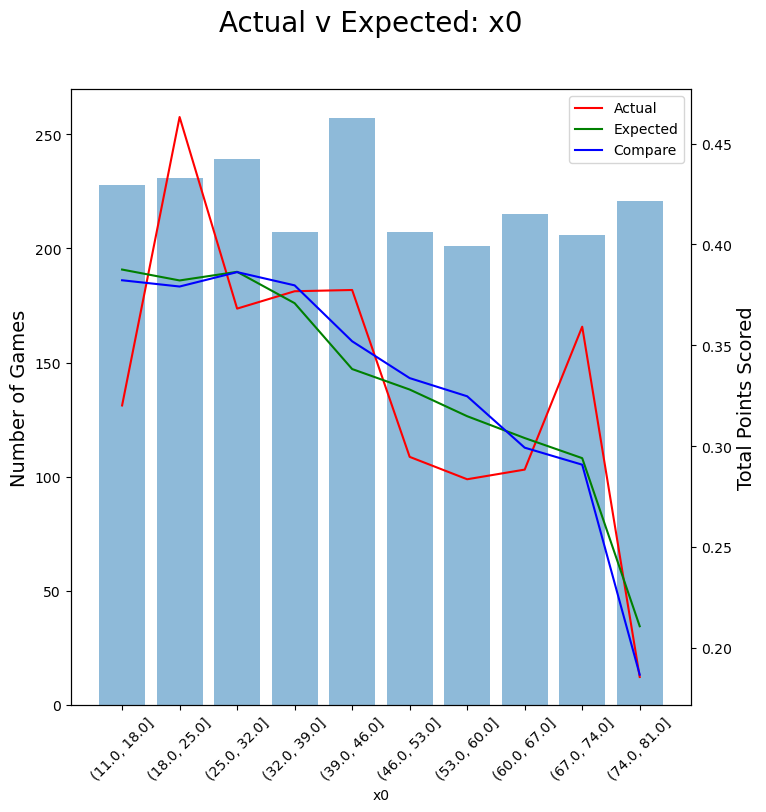

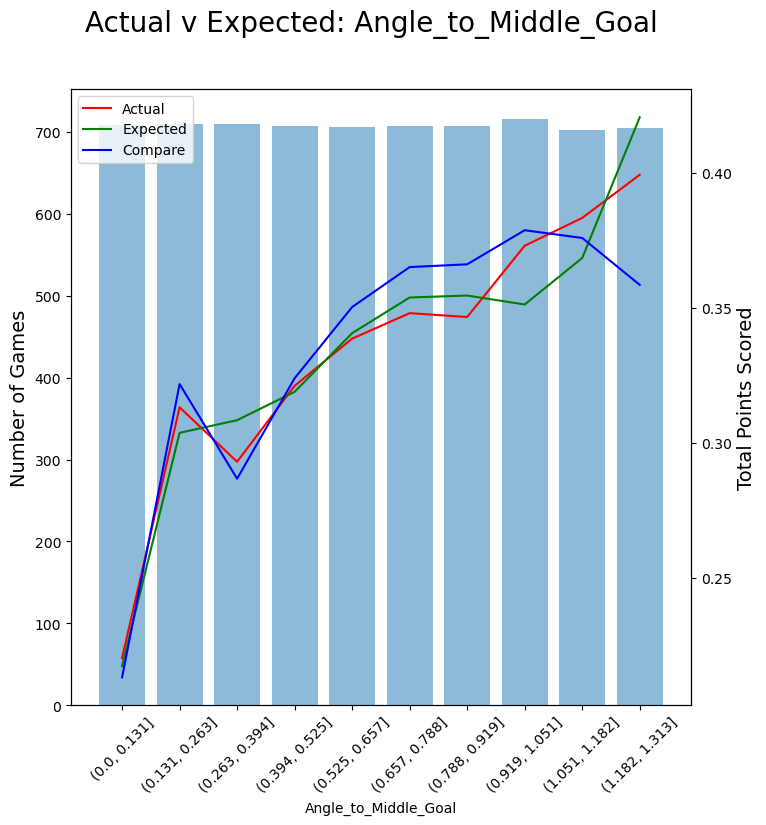

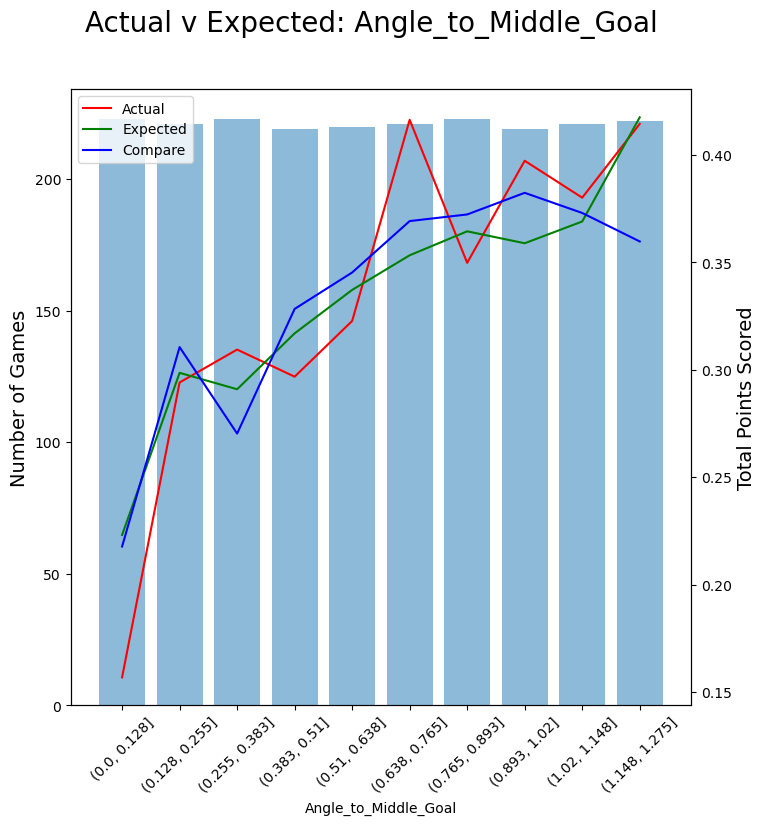

In [35]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [36]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.5998
Compare Log-Loss: 	0.6054
Expected Log-Loss: 	0.6002
Compare Log-Loss: 	0.6026


((0.5998050907092057, 0.5998050907092057),
 (0.6002387325423483, 0.6002387325423483))

In [37]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2086
Compare Brier Score: 	0.2108
Expected Brier Score: 	0.2095
Compare Brier Score: 	0.2104


((0.20864694525544167, 0.21079314569696309),
 (0.2094699634349387, 0.21039582278310334))

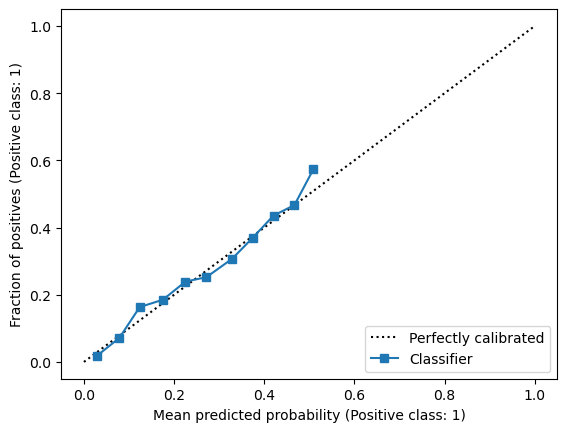

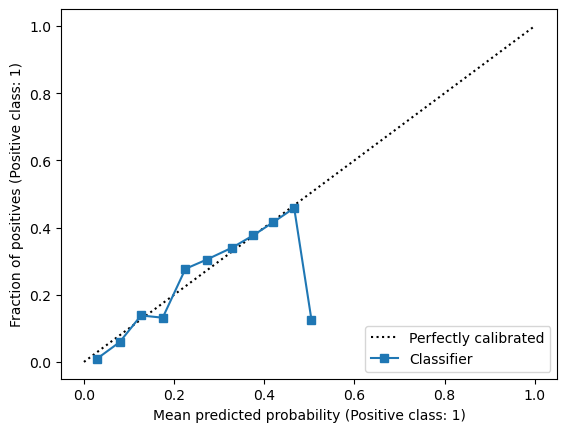

In [38]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

Potential New Features

In [ ]:
# list(df_modelling)

In [ ]:
potential_feature_list = [
    'Initial_State',
    'x0',
    'x1',
    'x2',
    'x3',
    'y0',
    'y1',
    'y2',
    'y3',
    'Quarter_Duration0',
    'Chain_Duration',
    'Time_Since_Last_Action',
    'Distance_Since_Last_Action',
    'Distance_to_Right_Goal_x',
    'Distance_to_Middle_y',
    'Visible_Goal_Angle',
    'Visible_Behind_Angle',
    'Squared_Distance_to_Middle_Goal',
    'Log_Distance_to_Middle_Goal'
]

In [ ]:
for col in potential_feature_list:
    train_xgb_evals.plot_feature_ave(col)